In [1]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from nilearn import plotting as ni_plt

import json, pickle
from tqdm import tqdm
import sys, os, pdb
import pandas as pd

from src.data_utils import ECoG_Data
import src.manifold_u as mu
import importlib
importlib.reload(mu)
import fig_utils as figu
importlib.reload(figu)

plt.style.use(['science', 'retro'])
sns.set_style("ticks")
plt.rcParams.update({"font.size": 10})

In [2]:
cur_freq = 'Beta'
cur_freq_ind = 2
freq_red_dim = 10

In [3]:
roi_region_shorthand = {'Parietal': 'Par',
                        'Postcentral': 'PostC',
                        'Precentral': 'PreC',
                        'Occipital': 'Occ',
                        'Angular': 'Ang',
                        'Frontal': 'Fro',
                        'SupraMarginal': 'SupM',
                        'Temporal': 'Temp',
                        'Heschl': 'Hes',
                        'Rolandic': 'Rol',
                        'Cerebellum': 'Cer',
                        'Fusiform': 'Fus',
                        }

In [4]:
roi_contrib_df = pd.read_csv('/home/zsteineh/research_projects/neural_manifolds/results/nm/exp_pca/roi_region_contrib_df.csv')
roi_contrib_df

,Unnamed: 0,Frequency,Participant,Day,Movement,PC Dimension,ROI Number,ROI Region,Contribution Weight
0,0,LFO,E01,0,1,0,0,Temporal,0.056598
1,1,LFO,E01,0,1,0,1,Temporal,0.037221
2,2,LFO,E01,0,1,0,2,Temporal,0.060800
3,3,LFO,E01,0,1,0,3,Temporal,0.076716
4,4,LFO,E01,0,1,0,4,Temporal,0.012979
...,...,...,...,...,...,...,...,...,...
419845,419845,High Gamma,E05,0,5,9,306,Precentral,0.109629
419846,419846,High Gamma,E05,0,5,9,307,Precentral,0.042511
419847,419847,High Gamma,E05,0,5,9,308,Frontal,0.154975
419848,419848,High Gamma,E05,0,5,9,309,Frontal,0.143285


In [5]:
# filter out non-LFO freqs
roi_contrib_df_LFO = roi_contrib_df[roi_contrib_df['Frequency'] == cur_freq]
roi_contrib_df_LFO

,Unnamed: 0,Frequency,Participant,Day,Movement,PC Dimension,ROI Number,ROI Region,Contribution Weight
116625,116625,Beta,E01,0,1,0,0,Temporal,0.104923
116626,116626,Beta,E01,0,1,0,1,Temporal,0.084725
116627,116627,Beta,E01,0,1,0,2,Temporal,0.107403
116628,116628,Beta,E01,0,1,0,3,Temporal,0.104057
116629,116629,Beta,E01,0,1,0,4,Temporal,0.059372
...,...,...,...,...,...,...,...,...,...
186595,186595,Beta,E05,0,5,8,306,Precentral,0.006615
186596,186596,Beta,E05,0,5,8,307,Precentral,0.017755
186597,186597,Beta,E05,0,5,8,308,Frontal,0.007601
186598,186598,Beta,E05,0,5,8,309,Frontal,0.024113


Index(['Parietal', 'Angular', 'Postcentral', 'Precentral', 'SupraMarginal',
       'Frontal', 'Occipital', 'Cerebellum', 'Rolandic', 'Temporal', 'Heschl',
       'Fusiform'],
      dtype='object', name='ROI Region')


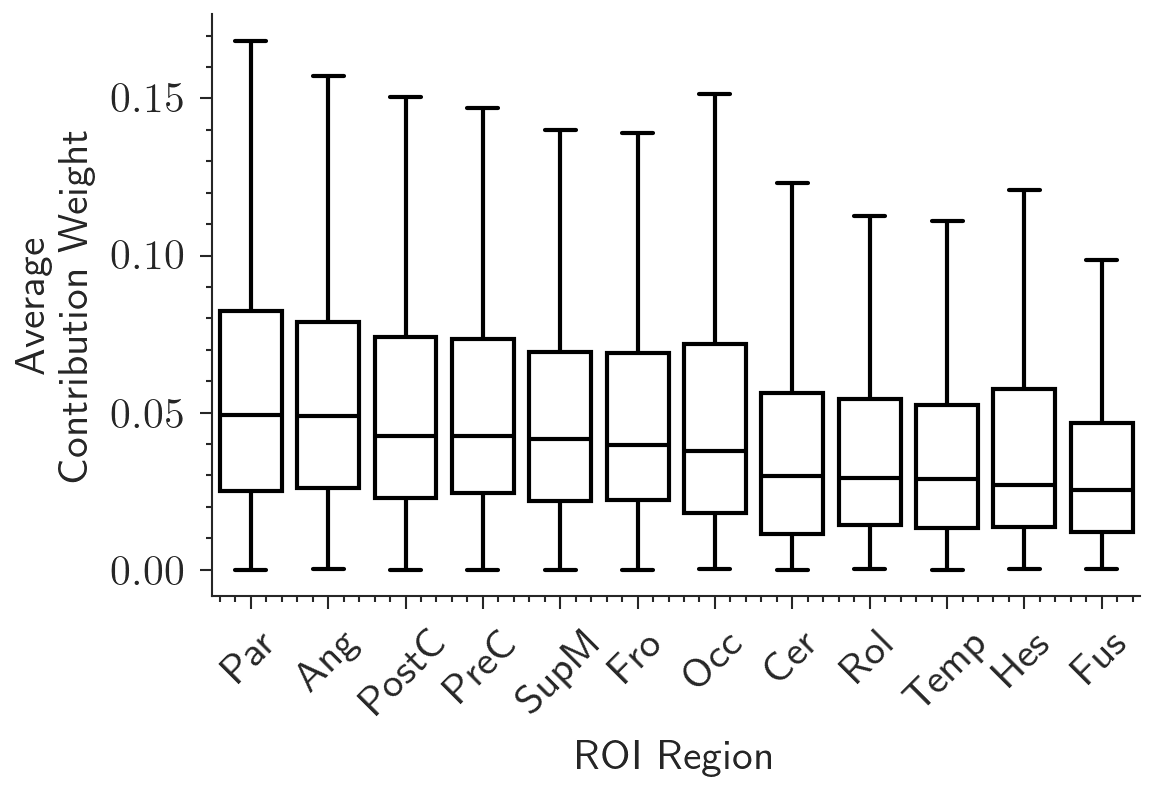

In [6]:
fig, ax = plt.subplots(figsize=(3.75, 2.5), dpi = 300)
plt.tight_layout()
plt.rcParams.update({"font.size": 12})
order = roi_contrib_df_LFO.groupby('ROI Region').median()['Contribution Weight'].sort_values(ascending=False).index
print(order)
ax = sns.boxplot(x='ROI Region', 
            y='Contribution Weight', 
            data=roi_contrib_df_LFO, 
            order=order,
            ax=ax,
            color='white',
            showfliers=False)
# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         ax.lines[j].set_color('black')

short_labels = [roi_region_shorthand[roi] for roi in order]
ax.set_xticklabels(labels=short_labels, rotation=45)
ax.set_ylabel("Average\nContribution Weight")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

In [7]:
print(roi_contrib_df_LFO.groupby('ROI Region').median()['Contribution Weight'].sort_values(ascending=False))
print(roi_contrib_df_LFO.groupby('ROI Region').std()['Contribution Weight'].sort_values(ascending=False))

ROI Region
Parietal         0.049180
Angular          0.048946
Postcentral      0.042511
Precentral       0.042426
SupraMarginal    0.041698
Frontal          0.039585
Occipital        0.037879
Cerebellum       0.029760
Rolandic         0.029131
Temporal         0.028714
Heschl           0.026953
Fusiform         0.025339
Name: Contribution Weight, dtype: float64
ROI Region
Occipital        0.041982
Parietal         0.039458
Angular          0.038230
Postcentral      0.037818
Precentral       0.037378
Frontal          0.034907
SupraMarginal    0.033657
Temporal         0.031632
Heschl           0.031357
Fusiform         0.030731
Cerebellum       0.030669
Rolandic         0.029100
Name: Contribution Weight, dtype: float64
